# OPOL Python Client

We are running all in local mode because the jupyter client will want to connect to the compose stack on localhost.
If you are using opol in scripts or services insides of containers please set it to "container".

### Initialization

#### Setup Client

In [22]:
from opol.main import OPOL
import os
from pprint import pprint

# 1. Setup client (using opol.io)
# opol = OPOL(api_key="")

# Alternatively - if you have booted the opol stack on your machine (no api key needed)
# Read opol/opol/stack/Readme.md for more information
opol = OPOL(mode="local")




#### Articles

In [ ]:
from opol.main import OPOL
import os
from pprint import pprint

opol = OPOL(mode="local", api_key="")

# Class submethods default to search
print(opol.articles.get_articles(query="apple"))
print(opol.articles("New York", pretty=True))    

# Use date
articles = opol.articles.get_articles("Berlin", limit=100)

entities = [article['title'] for article in articles[:3]]
entity_ids = [article['id'] for article in articles]
print(entities)
print(entity_ids)

geojson = opol.geo.by_id(entity_ids)
print(geojson[0]['features'])


In [ ]:
from opol.main import OPOL
import os
from pprint import pprint

opol = OPOL(mode="local", api_key="")

articles = opol.articles.by_entity("Trump", limit=100)

for article in articles:
    print(article.keys())
    print(f"{article['title']}:" + article['insertion_date'] + "\n")

#### Geojson & Geocoding

In [1]:
from opol.main import OPOL
import os

# set env variable
os.environ['OPOL_MODE'] = "local"

opol = OPOL(api_key="")

geojson = opol.geo.json_by_event("Politics", limit=5)
print(geojson)

berlin_coords = opol.geo.code("Berlin")["coordinates"]
print(berlin_coords)




/home/jimvincentwagner/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [77.294121, 28.625319]}, 'properties': {'location_id': '936e38e6-077c-4ce5-bb96-c42cc0161555', 'location_name': 'Middle East', 'location_type': 'unknown', 'content_count': 36, 'contents': [{'content_id': '8ee229d4-db51-42fe-b4a3-1f7a8e49cc4e', 'title': 'Here are the top 5 global economic challenges for 2025 – DW – 12', 'url': 'https://www.dw.com/en/here-are-the-top-5-global-economic-challenges-for-2025/a-71020698', 'source': 'DW', 'insertion_date': '2024-12-31T08:01:16.062791+00:00', 'classification': {'event_type': 'Politics', 'event_subtype': 'Elections', 'sociocultural_interest': 7, 'global_political_impact': 8, 'regional_political_impact': 7, 'global_economic_impact': 9, 'regional_economic_impact': 8}, 'top_entities': []}, {'content_id': '57281d39-3144-4e83-8f9c-3f1b0a5f1f3c', 'title': 'How will UK prepare for Trump? Keir Starmer, David Lammy and others draw up plans', 'url':

#### Polls

In [ ]:
from opol.main import OPOL
from pprint import pprint

opol = OPOL(mode="local", api_key="")

# polls = opol.scraping.polls("Germany")

# for pol in polls:
#     if pol['party'] == "GRÜNE" or pol['party'] == "CDU/CSU":
#         print(pol)


# Latest Polls for each Insittute
# polls = opol.scraping.polls("Germany", latest=True)

# for poll in polls:
#     print(poll)

ranked_polls = opol.scraping.polls("Germany", summarised=True)

for poll in ranked_polls:
    print(poll['party'] + ": " + str(poll['percentage']) + f" ({poll['change_since_election']})") 



### Legislation

In [ ]:
from opol.main import OPOL

opol = OPOL(api_key="")

events = opol.scraping.legislation("Germany")


for event in events[:1]:
    print(event)
        

### Economics

In [ ]:
from opol.main import OPOL

opol = OPOL(mode="local")

all_events = opol.scraping.economic("Germany")

gdp_events = opol.scraping.economic("Germany", indicators=["GDP"])


for event in all_events[:3]:
    print(event)

print("*"*20)

for event in gdp_events[:3]:
    print(event)

### LLM Classifications (custom llm wrapper)

In [2]:
from opol.api.classification import Classification
from opol.main import OPOL
import numpy as np
import os

# Initialize the OPOL client in local mode
opol = OPOL(mode="local")

# Set the API key for accessing the Google Generative AI service
# api_key = ""

# set env variable
os.environ['OPOL_MODE'] = "local"


# Initialize the classification service with the specified provider, model, and API key
xclass = opol.classification(provider="ollama", model_name="llama3.2:latest", llm_api_key="")

# Example 1: Classify user preference for frozen dairy products on a scale of 1 to 10
user_input = "I love ice cream"
prompt = "On a 1-10 scale how much the user likes frozen dairy products"
int_value = xclass.classify("int", prompt, user_input)
print("User preference rating:", int_value)

# Variance test
# Running the same classification 10 times
results = []
for i in range(10):
    results.append(xclass.classify("int", prompt, user_input))

variance = np.var(results)
print("Variance:", variance)

# Example 2: Extract keywords from a given text
text = "In the madagascan wilds the biggest wild animal is the elephant in the globe finance trade is offshore jusrisdiction diffusion"
instruction = "The topics relevant to this text. Only semantically relevant to a content system"
keywords = xclass.classify("List[str]", instruction, text)
print("Extracted keywords:", keywords)

# Example 3: Use a Pydantic model to classify request types with keywords and relevance level
from pydantic import BaseModel, Field
from typing import List

class RequestType(BaseModel):
    """
    This is the main classification for incoming request types.
    """
    keywords: List[str] = Field(description="The keywords relevant to this text. Only semantically relevant to a content system")
    relevance_level: int = Field(description="On a 1-10 scale how much the content is relevant")

# Classify the request using the Pydantic model
request = xclass.classify(RequestType, instruction, text)
print("Classified request:", request)

## Results
# User preference rating: 10
# Extracted keywords: ['madagascan', 'wilds', 'biggest', 'animal', 'elephant']
# Classified request: keywords=['madagascar', 'wildlife', 'elephant'] relevance_level=8






User preference rating: 5


InstructorRetryException: 1 validation error for DynamicSingleFieldModel
single_field
  Field required [type=missing, input_value={'@context': 'http://sche...ired': ['single_field']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing

In [ ]:
from opol.main import OPOL
import os
from pprint import pprint

# 1. Setup client (using opol.io)
# opol = OPOL(api_key="")

# Alternatively - if you have booted the opol stack on your machine (no api key needed)
# Read opol/opol/stack/Readme.md for more information
opol = OPOL(mode="local")


for poll in opol.scraping.polls("Germany", latest=True):
    print(poll)



### Search Engine (Google, Bing, Wikipedia, Axiv)

In [ ]:
from opol.main import OPOL
from pydantic import BaseModel
from typing import List, Optional

opol = OPOL(mode="local")

articles = opol.search.engine("Latest news from Gaza", engine="wikipedia")


for article in articles[:2]:
    print(article)

print("*"*20)
images = opol.search.image("Latest news from Gaza")

for image in images[:6]:
    print(image)



### Embeddings

In [ ]:
from opol.main import OPOL

opol = OPOL(mode="local")

embeddings = opol.embeddings("What is the capital of Germany?")

print(embeddings)
print(len(embeddings))


## Full Flow

In [ ]:
from opol.main import OPOL
from pydantic import BaseModel, Field
from typing import List
import os
import numpy as np

opol = OPOL(mode="local")
api_key = ""
fastclass = opol.classification(provider="Google", model_name="models/gemini-1.5-flash-latest", llm_api_key=api_key)


class ExpandedQuery(BaseModel):
    """
    As a political intelligence analyst, your task is to generate a set of three queries that delve deeper into geopolitical dynamics, building upon the initial query and the insights gathered from its search results.

    For instance, if the original query was "Middle East", your output should follow this format:

    [
        "Current political situation in the Middle East",
        "Recent military & conflict developments in the Middle East",
        "Economic assessments of the Middle East"
    ]


    Aim to create queries that progressively explore more specific geopolitical factors, implications, or related topics concerning the initial query. The goal is to anticipate the analyst's potential information needs and guide them towards a more comprehensive understanding of the geopolitical landscape.
    Please match the language of the response to the analyst's language.
    Also return the timeframe you want to search in, depending on the generality of the issue.
    Very detailed and specified queries are likely to inquire more recent content.  
    
    Return three queries.
    Return one timeframe, which is a literal of: [ day, month, year ]

    """
    similar: List[str] = None
    time_range: str = None

query = "Current developments in Gaza?"
instruction = ""
expanded_query = fastclass.classify(ExpandedQuery, instruction, query)

all_articles = []

# Collect articles (max 50)
counter = 0
for query in expanded_query.similar:
    articles = opol.search.engine(query, time_range=expanded_query.time_range)
    for article in articles:
        if counter > 70:
            break
        all_articles.append(article)
        counter += 1

# Rerank articles based on similarity to the query
query_embedding = opol.embeddings(query)
ranked_articles = opol.embeddings.rerank_articles(query_embedding, all_articles, text_field="title")

# Print top 2 ranked articles
for article in ranked_articles[:15]:
    for field in article[0]:
        print(field)

## Scrape a url


In [ ]:
from opol.main import OPOL

opol = OPOL(mode="local")

url = "https://www.dw.com/en//en/pakistans-punjab-imposes-activity-bans-amid-intense-smog/a-70755328"
scraped_url = opol.scraping.url(url)

print(scraped_url)

In [ ]:
from opol.main import OPOL

opol = OPOL(mode="remote", api_key="")

geocode = opol.geo.code("Berlin")

print(geocode)
articles = opol.search.engine("Latest news from Gaza", engine="wikipedia")

for article in articles:
    print(article)
    

In [ ]:
import requests
import regex as r
from bs4 import BeautifulSoup

def fetch_party_and_percentage():
    # Define the Wikipedia API URL for the opensearch endpoint
    search_url = "https://en.wikipedia.org/w/api.php"
    search_params = {
        "action": "opensearch",
        "search": "2021 German federal election",
        "limit": 1,
        "namespace": 0,
        "format": "json"
    }
    
    # Perform the search
    response = requests.get(search_url, params=search_params)
    search_results = response.json()
    
    # Extract the page URL from the search results
    if search_results and len(search_results) > 3 and search_results[3]:
        page_url = search_results[3][0]
    else:
        raise Exception("Wikipedia page not found.")
    
    # Fetch the page content
    page_response = requests.get(page_url)
    soup = BeautifulSoup(page_response.content, 'html.parser')
    
    # Find the election results table
    table = soup.find('table', {'class': 'infobox'})
    if not table:
        raise Exception("Election results table not found.")
    
    # Initialize a dictionary to hold data
    data = {
        'Party': [],
        'Percentage': []
    }
    
    # Iterate over table rows to extract data
    rows = table.find_all('tr')
    for row in rows:
        header = row.find('th')
        data_cells = row.find_all('td')
        if header and data_cells:
            key = header.get_text(strip=True)
            if key in data:
                for cell in data_cells:
                    text = cell.get_text(strip=True)
                    if text:
                        if key == 'Percentage':
                            text = r.search(r'\d{1,2}\.\d{1,2}', text).group(0)
                        data[key].append(text)
    
    # Print the extracted data
    for party, percentage in zip(data['Party'], data['Percentage']):
        print(f"Party: {party}, Percentage: {percentage}")

fetch_party_and_percentage()

from opol.main import OPOL
from pprint import pprint

opol = OPOL(mode="local", api_key="")

# polls = opol.scraping.polls("Germany")

# for pol in polls:
#     if pol['party'] == "GRÜNE" or pol['party'] == "CDU/CSU":
#         print(pol)


# Latest Polls for each Insittute
# polls = opol.scraping.polls("Germany", latest=True)

# for poll in polls:
#     print(poll)

ranked_polls = opol.scraping.polls("Germany", summarised=True)

for poll in ranked_polls:
    print(poll['party'] + ": " + str(poll['percentage']) + f" ({poll['change_since_election']})") 



In [4]:
from opol.main import OPOL
from opol.api.documents import Document

def test_documents():
    opol = OPOL(mode="local")
    docs = opol.documents

    # Test single document ingestion
    doc = Document(
        url="https://example.com/article1",
        title="Example Article 1",
        text_content="Test content 1",
        summary="Test summary 1"
    )
    print("Ingesting single document...")
    response = docs.ingest(doc, overwrite=True)
    print(f"Response: {response}\n")

    # Test multiple document ingestion
    multi_docs = [
        Document(
            url="https://example.com/article2",
            title="Example Article 2", 
            text_content="Test content 2",
            summary="Test summary 2"
        ),
        Document(
            url="https://example.com/article3",
            title="Example Article 3",
            text_content="Test content 3", 
            summary="Test summary 3"
        )
    ]
    print("Ingesting multiple documents...")
    response = docs.ingest(multi_docs, overwrite=True)
    print(f"Response: {response}")

    read_articles = docs.read(ids=response.content_ids)
    print(read_articles)
    print("*"*20)
    for article in read_articles:
        print(article)

    for article in read_articles:
        delete_response = docs.delete(id=article.id)
        print(delete_response)

if __name__ == "__main__":
    test_documents()

Ingesting single document...
Response: message='Documents ingested successfully.' content_ids=['fccef182-f0df-4dbd-95a6-cebf74a5b20a'] contents=None

Ingesting multiple documents...
Response: message='Documents ingested successfully.' content_ids=['fb8e3f1c-8e03-4e0a-aafc-58b9eb713c0c', 'f98fecb2-82ba-41f1-aec4-799c1229a307'] contents=None
[Document(id='fb8e3f1c-8e03-4e0a-aafc-58b9eb713c0c', url='https://example.com/article2', title='Example Article 2', content_type='article', source=None, text_content='Test content 2', insertion_date='2025-01-10T17:30:51.052560+00:00', summary='Test summary 2', meta_summary=None, media_details=None), Document(id='f98fecb2-82ba-41f1-aec4-799c1229a307', url='https://example.com/article3', title='Example Article 3', content_type='article', source=None, text_content='Test content 3', insertion_date='2025-01-10T17:30:51.056195+00:00', summary='Test summary 3', meta_summary=None, media_details=None)]
********************
id='fb8e3f1c-8e03-4e0a-aafc-58b9eb71

In [2]:
from opol.main import OPOL

opol = OPOL(mode="local", api_key="")


articles = opol.articles.by_entity("Germany")
for article in articles:
    print(article) 

{'id': '3610c09d-8399-422e-8bdf-62bf6f26fe7f', 'url': 'https://www.bbc.com/news/articles/c2kxl45kev0o', 'title': 'The World War Two soldier buried in Germany without his brain', 'source': 'BBC News', 'insertion_date': '2025-01-22T02:25:25.131033+00:00', 'text_content': 'The World War Two soldier buried without his brain\n\nScottish soldier Donnie MacRae died as a German prisoner of war during World War Two - but it was not until almost 80 years later that his family discovered he had been buried without his brain.\n\nDonnie died in a PoW hospital in 1941 and because he had suffered with a rare neurological condition an autopsy was performed on his body.\n\nDuring the post-mortem, his brain and part of his spinal cord were removed and sent to the Kaiser Wilhelm Institute for Psychiatry in Munich to be used for research.\n\nHis body was buried by the Germans and later reburied by the Allies in the Commonwealth War Graves cemetery in Berlin but no-one knew his brain had been removed.\n\nI

In [1]:
# Import necessary libraries
from opol.api import Geo
from datetime import datetime, timedelta, timezone
import json
import folium
from IPython.display import display

# Initialize the Geo client (use "local" or "remote" as appropriate for your environment)
geo_client = Geo(mode="local")  # or "remote" for production

# Define a specific date range
# Going back 30 days from today
end_date = datetime.now(timezone.utc).isoformat()
start_date = (datetime.now(timezone.utc) - timedelta(days=30)).isoformat()

# Get politics events from the last 30 days
politics_data = geo_client.json_by_event(
    event_type="Politics",
    start_date=start_date,
    end_date=end_date,
    limit=100
)

# Print some statistics
feature_count = len(politics_data.get("features", []))
print(f"Retrieved {feature_count} locations with political events from {start_date[:10]} to {end_date[:10]}")

# Visualize on a map
if feature_count > 0:
    # Create a folium map centered around the first location
    first_location = politics_data["features"][0]["geometry"]["coordinates"]
    m = folium.Map(location=[first_location[1], first_location[0]], zoom_start=3)
    
    # Add markers for each location
    for feature in politics_data["features"]:
        coords = feature["geometry"]["coordinates"]
        location_name = feature["properties"]["location_name"]
        content_count = feature["properties"]["content_count"]
        
        popup_html = f"""
        <b>{location_name}</b><br>
        Content count: {content_count}<br>
        """
        
        folium.Marker(
            location=[coords[1], coords[0]],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=location_name
        ).add_to(m)
    
    # Display the map
    display(m)
else:
    print("No data found for the specified date range")

/home/jimvincentwagner/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Retrieved 29 locations with political events from 2025-02-12 to 2025-03-14


,Locations,Total Content,Top Locations
Last week,3,17,"DC (15), Californian desert (1), Joshua Tree (1)"
Last month,3,17,"DC (15), Californian desert (1), Joshua Tree (1)"
Last quarter,3,17,"DC (15), Californian desert (1), Joshua Tree (1)"


Map for Last week saved as protests_map_last_week.html
Map for Last month saved as protests_map_last_month.html
Map for Last quarter saved as protests_map_last_quarter.html

Open the saved HTML files to view the maps for each time period.


<Figure size 1500x1000 with 0 Axes>

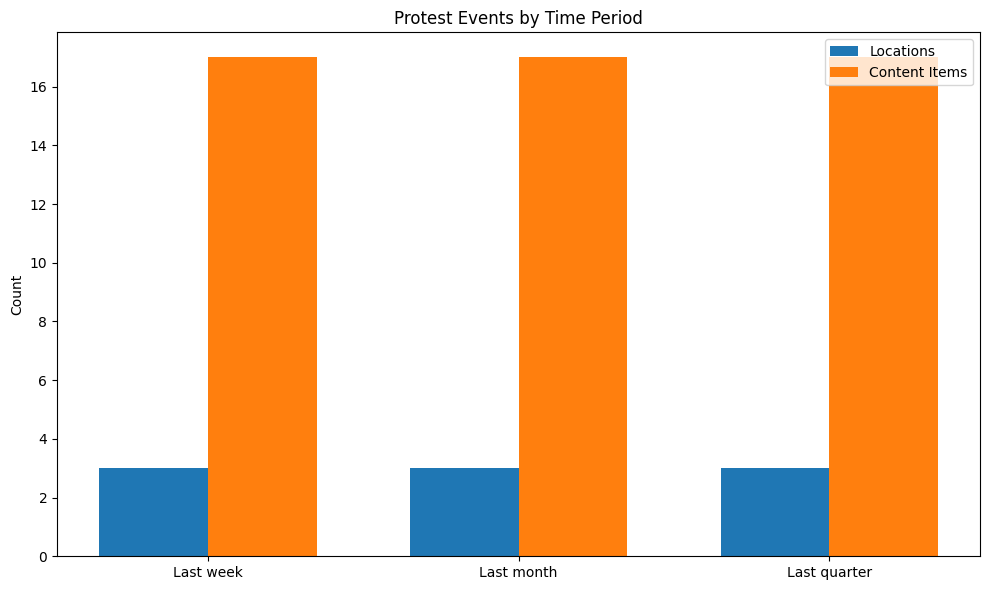

In [2]:
# Import necessary libraries
from opol.api import Geo
from datetime import datetime, timedelta, timezone
import json
import folium
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Geo client
geo_client = Geo(mode="local")  # or "remote" for production

# Define different time periods to compare
now = datetime.now(timezone.utc)
time_periods = {
    "Last week": (now - timedelta(days=7)).isoformat(),
    "Last month": (now - timedelta(days=30)).isoformat(),
    "Last quarter": (now - timedelta(days=90)).isoformat()
}

# Collect data for each time period
protest_data = {}
for period_name, start_date in time_periods.items():
    data = geo_client.json_by_event(
        event_type="Protests",
        start_date=start_date,
        end_date=now.isoformat(),
        limit=150
    )
    protest_data[period_name] = data

# Create a comparison dataframe
comparison = {}
for period, data in protest_data.items():
    features = data.get("features", [])
    location_counts = len(features)
    
    # Count total content items
    content_total = sum(feature["properties"]["content_count"] for feature in features) if features else 0
    
    # Get top locations by content count
    top_locations = []
    if features:
        sorted_features = sorted(features, key=lambda x: x["properties"]["content_count"], reverse=True)
        top_locations = [f"{f['properties']['location_name']} ({f['properties']['content_count']})" 
                        for f in sorted_features[:5]]
    
    comparison[period] = {
        "Locations": location_counts,
        "Total Content": content_total,
        "Top Locations": ", ".join(top_locations) if top_locations else "None"
    }

# Create a DataFrame for display
comparison_df = pd.DataFrame.from_dict(comparison, orient='index')
display(comparison_df)

# Create a multi-map visualization to compare periods
fig = plt.figure(figsize=(15, 10))
for i, (period_name, data) in enumerate(protest_data.items(), 1):
    features = data.get("features", [])
    
    if not features:
        continue
        
    # Create a folium map
    m = folium.Map(zoom_start=2)
    
    # Add markers for each location
    for feature in features:
        coords = feature["geometry"]["coordinates"]
        location_name = feature["properties"]["location_name"]
        content_count = feature["properties"]["content_count"]
        
        # Use circle markers with size proportional to content count
        folium.CircleMarker(
            location=[coords[1], coords[0]],
            radius=min(content_count * 2, 20),  # Scale the size but cap it
            popup=f"{location_name}: {content_count} items",
            tooltip=location_name,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(m)
    
    # Save each map to an HTML file
    map_file = f"protests_map_{period_name.replace(' ', '_').lower()}.html"
    m.save(map_file)
    
    print(f"Map for {period_name} saved as {map_file}")

print("\nOpen the saved HTML files to view the maps for each time period.")

# Let's also create a bar chart to compare the number of locations across time periods
location_counts = [comparison[period]["Locations"] for period in time_periods.keys()]
content_counts = [comparison[period]["Total Content"] for period in time_periods.keys()]

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(time_periods))
width = 0.35

bar1 = ax.bar([i - width/2 for i in x], location_counts, width, label='Locations')
bar2 = ax.bar([i + width/2 for i in x], content_counts, width, label='Content Items')

ax.set_ylabel('Count')
ax.set_title('Protest Events by Time Period')
ax.set_xticks(x)
ax.set_xticklabels(list(time_periods.keys()))
ax.legend()

plt.tight_layout()
plt.show()